In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lhapdf
import fdss
from iminuit import Minuit
from data import Sivers_data

In [2]:
lhapdf.setVerbosity(0)
pdf = lhapdf.mkPDF("cteq6l1", 0)

In [3]:
def Aut(x, pT, z, Q2, Au, Ad, Nu, Nd, Bu, Bd, kperp2S, exp, had):
    eqp2 = 4.0/9.0
    eqn2 = 1.0/9.0
    mP = 0.938

    #PDFs
    ux_p  = pdf.xfxQ2( 2, x, Q2) / x
    dx_p  = pdf.xfxQ2( 1, x, Q2) / x
    sx_p  = pdf.xfxQ2( 3, x, Q2) / x
    ubx_p = pdf.xfxQ2(-2, x, Q2) / x
    dbx_p = pdf.xfxQ2(-1, x, Q2) / x
    sbx_p = pdf.xfxQ2(-3, x, Q2) / x

    ux_n  = dx_p
    dx_n  = ux_p
    sx_n  = sx_p
    ubx_n = dbx_p
    dbx_n = ubx_p
    sbx_n = sbx_p

    #Fragmentation functions
    if had == "pi+":
        ih ,ic = 1, 1
    elif had == "pi-":
        ih ,ic = 1, -1
    elif had == "pi0":  
        ih ,ic = 1, 0
    elif had == "K+":  
        ih ,ic = 2, 1
    elif had == "K0":  
        ih ,ic = 2, 0
    elif had == "h+":  
        ih ,ic = 4, 1
    elif had == "h-":  
        ih ,ic = 4, -1
    else:
        raise ValueError(f"Unknown Hadron = {had}")
    zu, zub, zd, zdb, zs, zsb, zc, zb, zgl = fdss.fdss(ih,ic,0,z,Q2)

    if exp == "HERMES2009" or exp == "JLab":
        Av_kperp2 = 0.57
        Av_pperp2 = 0.12
    elif (exp == "COMPASS2010" or exp == "COMPASS2017_BIN_1" or exp == "COMPASS2017_BIN_2" 
          or exp == "COMPASS2017_BIN_3" or exp == "COMPASS2017_BIN_4"):
        Av_kperp2 = 0.60
        Av_pperp2 = 0.20
    else:
        raise ValueError(f"Unknown Experiment = {exp}")
    
    Av_pT2  = Av_pperp2 + z*z*Av_kperp2
    Av_pT2S = Av_pperp2 + z*z*kperp2S

    Au_p, Ad_p = Au, Ad
    Bu_p, Bd_p = Bu, Bd
    Nu_p, Nd_p = Nu, Nd

    Au_n, Ad_n = Ad, Au
    Bu_n, Bd_n = Bd, Bu
    Nu_n, Nd_n = Nd, Nu

    #Final expresions
    if exp == "COMPASS2010":

        fuu = ( np.exp(-pT**2 / Av_pT2) / (np.pi * Av_pT2) ) * (
            eqp2 * (ux_p + ux_n) * zu/z +
            eqn2 * (dx_p + dx_n) * zd/z +
            eqn2 * (sx_p + sx_n) * zs/z +
            eqp2 * (ubx_p + ubx_n) * zub/z +
            eqn2 * (dbx_p + dbx_n) * zdb/z +
            eqn2 * (sbx_p + sbx_n) * zsb/z
        )

        fut = (
            2.0 * z * (pT * mP / Av_pT2S)
            * ( np.exp(-pT**2 / Av_pT2S) / (np.pi * Av_pT2S) )
            * (
                eqp2 * (
                    Nu_p * x**Au_p * (1-x)**Bu_p * zu/z +
                    Nu_n * x**Au_n * (1-x)**Bu_n * zu/z
                )
                +
                eqn2 * (
                    Nd_p * x**Ad_p * (1-x)**Bd_p * zd/z +
                    Nd_n * x**Ad_n * (1-x)**Bd_n * zd/z
                )
            )
        )


    elif exp == "HERMES2009" or exp == "COMPASS2017_BIN_1" or exp == "COMPASS2017_BIN_2" or exp == "COMPASS2017_BIN_3" or exp == "COMPASS2017_BIN_4":

        fuu = ( np.exp(-pT**2 / Av_pT2) / (np.pi * Av_pT2) ) * (
            eqp2 * ux_p * zu/z +
            eqp2 * ubx_p * zub/z +
            eqn2 * dx_p * zd/z +
            eqn2 * dbx_p * zdb/z +
            eqn2 * sx_p * zs/z +
            eqn2 * sbx_p * zsb/z
        )

        fut = (
            2.0 * z * (pT * mP / Av_pT2S)
            * ( np.exp(-pT**2 / Av_pT2S) / (np.pi * Av_pT2S) )
            * (
                eqp2 * Nu_p * x**Au_p * (1-x)**Bu_p * zu/z +
                eqn2 * Nd_p * x**Ad_p * (1-x)**Bd_p * zd/z
            )
        )

    elif exp == "JLab":

        fuu = ( np.exp(-pT**2 / Av_pT2) / (np.pi * Av_pT2) ) * (
            eqp2 * ux_n * zu/z +
            eqp2 * ubx_n * zub/z +
            eqn2 * dx_n * zd/z +
            eqn2 * dbx_n * zdb/z +
            eqn2 * sx_n * zs/z +
            eqn2 * sbx_n * zsb/z
        )

        fut = (
            2.0 * z * (pT * mP / Av_pT2S)
            * ( np.exp(-pT**2 / Av_pT2S) / (np.pi * Av_pT2S) )
            * (
                eqp2 * Nu_n * x**Au_n * (1-x)**Bu_n * zu/z +
                eqn2 * Nd_n * x**Ad_n * (1-x)**Bd_n * zd/z
            )
        )

    else:
        raise ValueError(f"Unknown Experiment = {exp}")

    return fut / fuu

In [4]:
datasets_to_fit = []
experiments = ["HERMES2009", "COMPASS2010", "COMPASS2017_BIN_1", "COMPASS2017_BIN_2", "COMPASS2017_BIN_3", "COMPASS2017_BIN_4", "JLab"]
hadrons = ["pi+", "pi-", "pi0", "K+", "K0", "h+", "h-"]
dependences = ["x", "pT"]

In [5]:
for exp in experiments:
    if exp not in Sivers_data:
        continue
    for had in hadrons:
        if had not in Sivers_data[exp]:
            continue
        for dep in dependences:
            if dep not in Sivers_data[exp][had]:
                continue
            dataset = Sivers_data[exp][had][dep]
            if isinstance(dataset, dict) and "A" in dataset:
                datasets_to_fit.append((exp, had, dep))

In [6]:
def chi2(Au, Ad, Nu, Nd, Bu, Bd, kperp2S):

    total_chi2 = 0.0

    for exp, had, dep in datasets_to_fit:

        dataset = Sivers_data[exp][had][dep]

        x_vals  = np.array(dataset["x"])
        Q2_vals = np.array(dataset["Q2"])
        z_vals  = np.array(dataset["z"])
        pT_vals = np.array(dataset["pT"])
        A_data  = np.array(dataset["A"])
        errors  = np.array(dataset["stat"])

        for i in range(len(x_vals)):

            th = Aut(x_vals[i], pT_vals[i], z_vals[i], Q2_vals[i], Au, Ad, Nu, Nd, Bu, Bd, kperp2S, exp, had)

            total_chi2 += ((A_data[i] - th) / errors[i])**2

    return total_chi2

In [7]:
m = Minuit(chi2, Au=0.0, Ad=0.0, Nu=0.4, Nd=-0.6, Bu=5.0, Bd=6.0, kperp2S=0.3)

m.fixed["Au"] = True
m.fixed["Ad"] = True

#m.limits["Au"] = (-1.0, 1.0)
#m.limits["Ad"] = (-1.0, 1.0)
m.limits["Nu"] = (-1.0, 1.0)
m.limits["Nd"] = (-1.0, 1.0)
m.limits["Bu"] = (0.0, 10.0)
m.limits["Bd"] = (0.0, 10.0)
m.limits["kperp2S"] = (0.0, 1.0)

m.errordef = 4
m.migrad()
m.hesse()

npoints = 0
for exp, had, dep in datasets_to_fit:
    npoints += len(Sivers_data[exp][had][dep]["A"])

ndof = npoints - m.nfit

print("\nTotal points =", npoints)
print("chi2/ndof =", m.fval/ndof)
print(m)


Total points = 220
chi2/ndof = 1.179486594414726
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 253.6                      │              Nfcn = 155              │
│ EDM = 0.000626 (Goal: 0.0008)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────

In [8]:
def plot_sivers(Sivers_data,
                exp, had, dep,
                Au, Ad, Nu, Nd, Bu, Bd, kperp2S):

    data = Sivers_data[exp][had][dep]

    x_data  = np.array(data["x"])
    z_data  = np.array(data["z"])
    pT_data = np.array(data["pT"])
    Q2_data = np.array(data["Q2"])
    A_data  = np.array(data["A"])
    err     = np.array(data["stat"])

    A_th = np.array([
        Aut(x_data[i],
            pT_data[i],
            z_data[i],
            Q2_data[i],
            Au, Ad, Nu, Nd, Bu, Bd, kperp2S,
            exp, had)
        for i in range(len(x_data))
    ])

    plt.figure(figsize=(5,4))
    plt.errorbar(x_data, A_data, yerr=err,
                 fmt='o', capsize=3)
    plt.plot(x_data, A_th)

    plt.xlabel(dep)
    plt.ylabel(r"$A_{UT}^{\sin(\phi_h-\phi_S)}$")
    plt.title(f"{exp}  {had}")

    plt.tight_layout()
    plt.show()

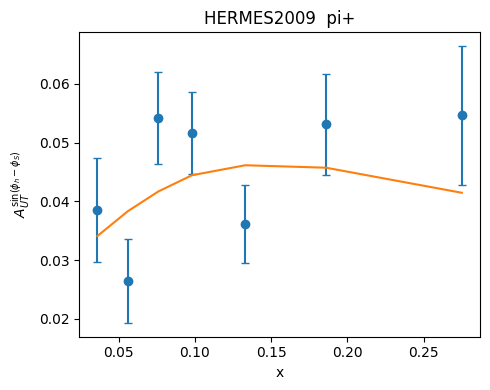

In [9]:
plot_sivers(Sivers_data, "HERMES2009", "pi+", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

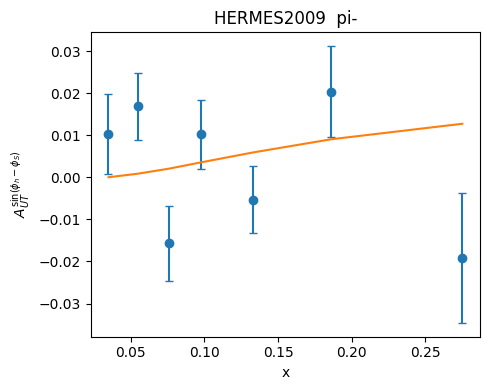

In [10]:
plot_sivers(Sivers_data, "HERMES2009", "pi-", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

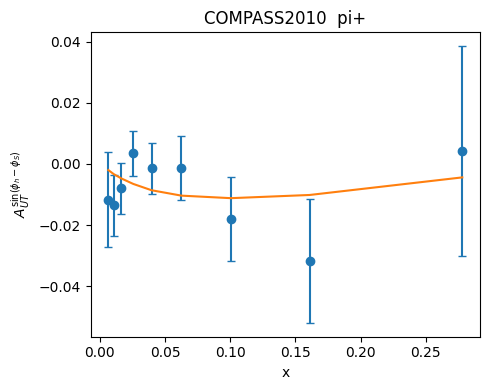

In [11]:
plot_sivers(Sivers_data, "COMPASS2010", "pi+", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

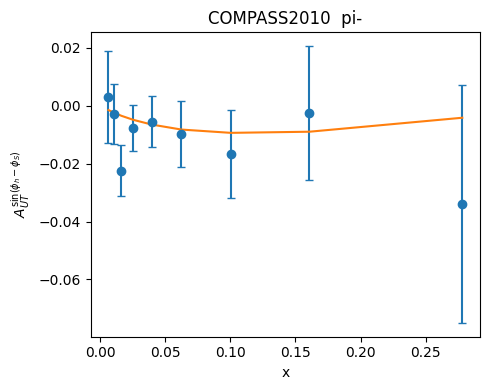

In [12]:
plot_sivers(Sivers_data, "COMPASS2010", "pi-", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

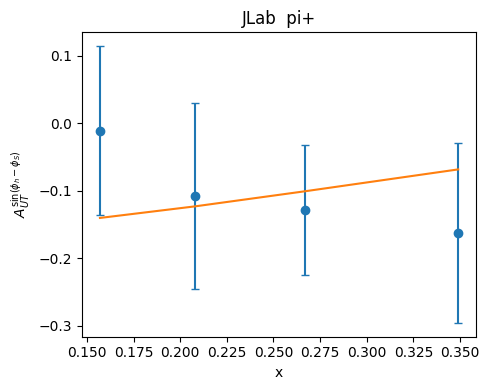

In [13]:
plot_sivers(Sivers_data, "JLab", "pi+", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

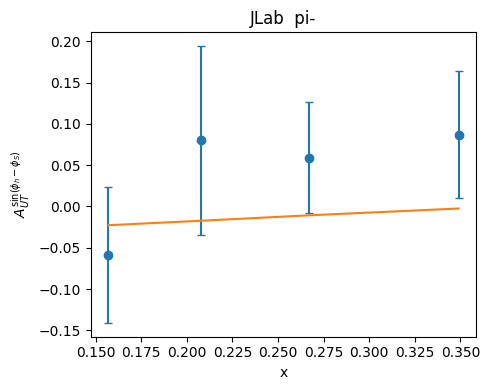

In [14]:
plot_sivers(Sivers_data, "JLab", "pi-", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

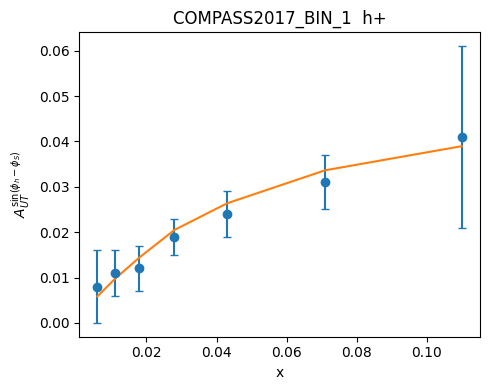

In [15]:
plot_sivers(Sivers_data, "COMPASS2017_BIN_1", "h+", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

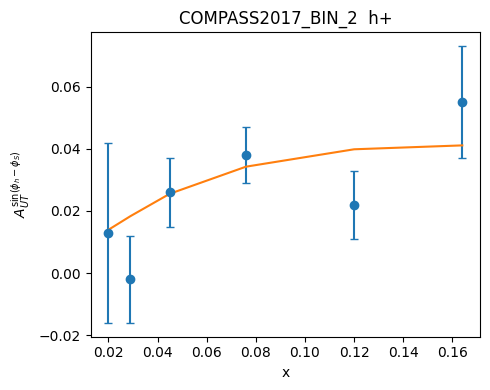

In [16]:
plot_sivers(Sivers_data, "COMPASS2017_BIN_2", "h+", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

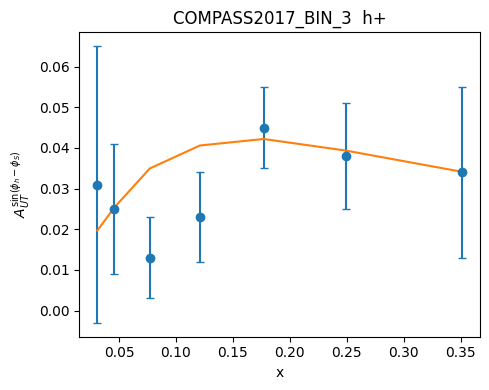

In [17]:
plot_sivers(Sivers_data, "COMPASS2017_BIN_3", "h+", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

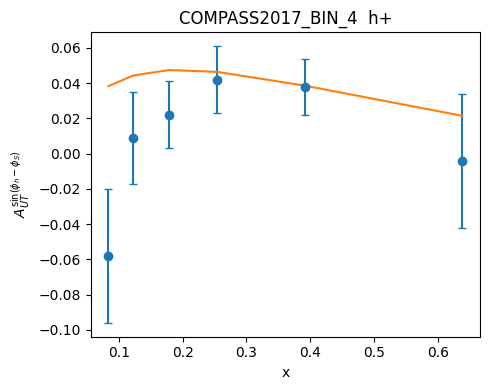

In [18]:
plot_sivers(Sivers_data, "COMPASS2017_BIN_4", "h+", "x", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

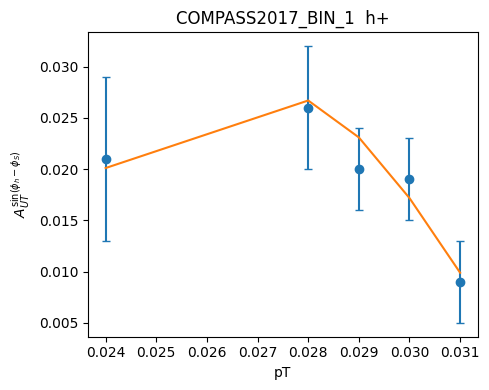

In [19]:
plot_sivers(Sivers_data, "COMPASS2017_BIN_1", "h+", "pT", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

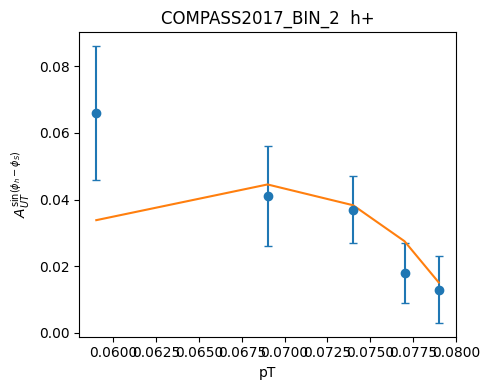

In [20]:
plot_sivers(Sivers_data, "COMPASS2017_BIN_2", "h+", "pT", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

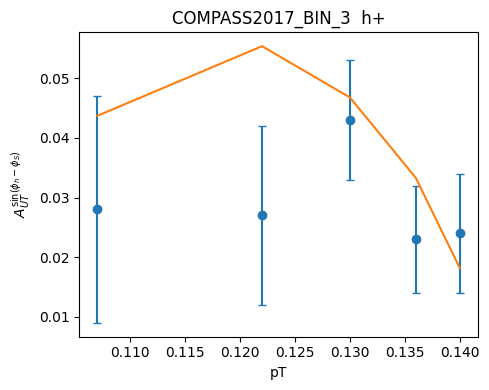

In [21]:
plot_sivers(Sivers_data, "COMPASS2017_BIN_3", "h+", "pT", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)

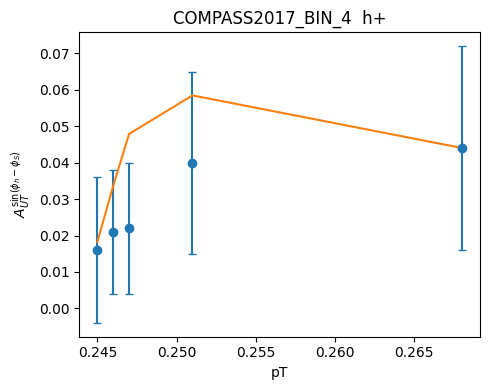

In [22]:
plot_sivers(Sivers_data, "COMPASS2017_BIN_4", "h+", "pT", 0.0, 0.0, 0.40, -0.63, 5.43, 6.45, 0.30)